In [1]:
from sklearn.cluster import SpectralClustering
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib
import time
import matplotlib.pyplot as plt
from numpy import linalg as LA
import os

In [100]:
# Load the data
def to_np_edge_array(graph_edges):
    edges = []
    for (u, v) in graph_edges:
        edges.append((u, v))
    return np.array(edges, dtype=('int, int'))

def read_graph(filepath):
    # Use the largest connected component from the graph
    graph = nx.read_edgelist(filepath, nodetype=int).to_undirected()
    graph.name = os.path.basename(filepath)
    graph = max(nx.connected_component_subgraphs(graph), key=len)
    
    # Split the graph edges into train and test
    random_edges = to_np_edge_array(graph.edges())
    np.random.shuffle(random_edges)
    train_edges = random_edges[:graph.number_of_edges()//2]
    test_edges = random_edges[graph.number_of_edges()//2:]
    
    # Create the training graph
    train_graph = nx.Graph()
    train_graph.add_edges_from(train_edges)
    train_graph = max(nx.connected_component_subgraphs(train_graph), key=len)
    
    # Create the test graph
    test_graph = nx.Graph()
    test_graph.add_edges_from(test_edges)
    
    return train_graph, test_graph
    
email_graph, email_graph_test = read_graph("./dataset/email-Eu-core.txt")

In [101]:
# Compare the eigenvectors of the vanilla and regularised graphs
def get_eigen(S):
    DS = np.diag(1. / np.sqrt(np.ravel((np.sum(S, 1)))))
    L = np.identity(np.shape(S)[0]) - np.matmul(np.matmul(DS, S), DS)
    val, vec = LA.eig(L)
    
    # Transform the egigenvalues and vectors of L into those of S(D^{-1})
    return 1 - val, np.transpose(np.matmul(DS, np.transpose(vec)))

S = nx.to_numpy_matrix(email_graph)

# Tao is initialised with the average degree of the graph
N = email_graph.number_of_nodes()
tao = np.mean(np.ravel(np.sum(S, 1))) 
SR = S + tao / N

val_van, vec_van = get_eigen(S)
val_reg, vec_reg = get_eigen(SR)

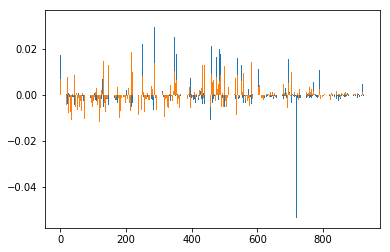

In [102]:
# Compare the eigenvectors of the laplacian of the two graphs
def plot_array(eigenval1, eigenval2, num_bins=50):
    plt.bar(np.arange(len(eigenval1)), eigenval1)
    plt.bar(np.arange(len(eigenval2)), eigenval2)
    plt.show()
    
plot_array(np.ravel(vec_van[:, 2]), np.ravel(vec_reg[:, 2]))
# plot_array(np.ravel(vec_van[:, 3]), np.ravel(vec_reg[:, 3]))
# plot_array(np.ravel(vec_van[:, 4]), np.ravel(vec_reg[:, 4]))

In [105]:
# Compute the number of nodes in the smallest partition set.
sc_van = SpectralClustering(2, affinity='precomputed', n_init=100).fit(S)
sc_reg = SpectralClustering(2, affinity='precomputed', n_init=100).fit(SR)

van_min_part_size = min(np.sum(sc_van.labels_), N - np.sum(sc_van.labels_))
reg_min_part_size = min(np.sum(sc_reg.labels_), N - np.sum(sc_reg.labels_))
print(van_min_part_size)
print(reg_min_part_size)

61
197


In [104]:
# Bechmark the execution time for the computation of eigenvalues for the two matrices
def benchmark(fct):   
    start = time.time()
    fct()
    end = time.time()
    return end-start

van_times, reg_times = [], []
runs = 10

for run in range(runs):
    van_times.append(benchmark(lambda: get_eigen(S)))
    reg_times.append(benchmark(lambda: get_eigen(SR)))

print("{}+-{}".format(np.mean(van_times), np.std(van_times)))
print("{}+-{}".format(np.mean(reg_times), np.std(reg_times)))

0.5780939340591431+-0.031316405182095254
0.573853325843811+-0.06639979828971815
